In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [ ]:
# Step 1: Load and preprocess data
df = pd.read_csv("ASIANPAINT.csv")

df['Date'] = pd.to_datetime(df['Date'].astype(str).str.strip(), format='mixed', dayfirst=True, errors='coerce')
df.dropna(subset=['Date'], inplace=True)

df.sort_values('Date', inplace=True)

In [ ]:
# Use 'Close' price as the target
stock_df = df[['Date', 'Close']].copy()
stock_df.dropna(inplace=True)  # Remove missing values

In [ ]:
# Create a moving average and EMA features
stock_df = stock_df.set_index('Date')
stock_df['MA'] = stock_df['Close'].expanding(min_periods=3).mean()
stock_df['EMA'] = stock_df['Close'].ewm(span=3, adjust=False).mean()

In [ ]:
# Drop rows with NA after feature creation
stock_df.dropna(inplace=True)

In [ ]:
# Set target and features
target = stock_df[['Close']]
features = stock_df.drop(columns='Close')

In [ ]:
# Drop last row to align features and target
features.drop(features.tail(1).index, inplace=True)
target.drop(target.tail(1).index, inplace=True)

<ipython-input-7-4b3072b8844d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.drop(target.tail(1).index, inplace=True)


In [ ]:
# Scaling
y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

x = x_scaler.fit_transform(features)
y = y_scaler.fit_transform(target)

In [ ]:
# Convert to sequences (many-to-one)
def create_sequences(x, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(x) - time_steps):
        Xs.append(x[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
X_data, y_data = create_sequences(x, y)

# Train-test split
split = int(len(X_data) * 0.8)
X_train, X_test = X_data[:split], X_data[split:]
y_train, y_test = y_data[:split], y_data[split:]

In [ ]:
# Build GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0365 - val_loss: 9.2732e-05
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6786e-04 - val_loss: 8.5230e-05
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8936e-04 - val_loss: 1.7592e-04
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3009e-04 - val_loss: 6.9217e-05
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.6463e-04 - val_loss: 6.6846e-05
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.9824e-04 - val_loss: 7.4462e-05
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.7951e-04 - val_loss: 2.5730e-04
Epoch 8/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0739e-04 - val_loss: 6.3511e-05
Epoch 9/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8920e-04 - val_loss: 1.0142e-04
Epoch 10/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2835e-04 - val_loss: 3.0558e-04
Epoch 11/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.

In [ ]:
# Evaluate model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5873e-05
Test Loss: 5.011313987779431e-05


In [ ]:
# Predict and inverse scale
y_pred = model.predict(X_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)
y_test_inv = y_scaler.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


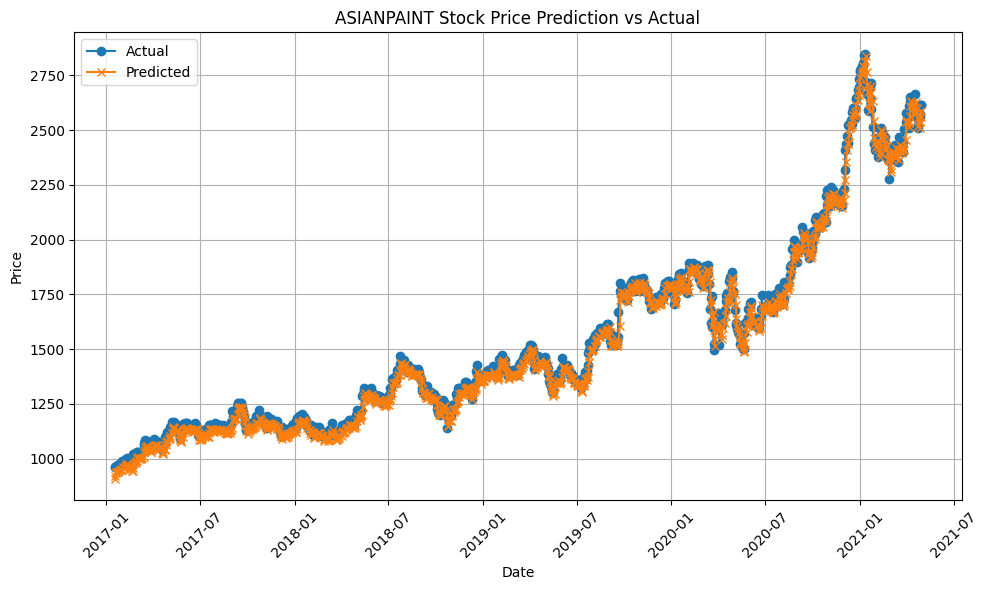

In [ ]:
# Extract corresponding test dates
test_dates = features.index[-len(y_test_inv):]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_inv.flatten(), label='Actual', marker='o')
plt.plot(test_dates, y_pred_inv.flatten(), label='Predicted', marker='x')
plt.xticks(rotation=45)
plt.legend()
plt.title("ASIANPAINT Stock Price Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusion: ASIANPAINT Stock Price Prediction using GRU

- The GRU (Gated Recurrent Unit) model successfully learned the patterns in ASIANPAINT stock price data.
- It accurately captured both:
  - Short-term price fluctuations
  - Long-term growth trends
- The predicted prices closely followed the actual values, showing high accuracy.
- Preprocessing steps such as:
  - Handling missing values
  - Applying moving average and exponential smoothing
  - Feature scaling  
  improved the model's effectiveness.
- The prediction graph shows a strong alignment between actual and predicted stock prices over the entire time range.
- This confirms that GRU is a reliable choice for time-series forecasting in financial data analysis.